# classification

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from transformers import AutoTokenizer, AutoModel

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix
)
from sklearn.utils.multiclass import unique_labels

df = pd.read_csv("./Relevant dataset/ae_to_soc_cluster.csv", dtype=str)
df["ae_text"] = df["Adverse Events"].astype(str).str.strip().str.lower().fillna("")
df["label"]   = df["SOC Cluster"].astype(str).str.strip().str.lower().fillna("")

label_counts  = df["label"].value_counts()
rare_labels   = label_counts[label_counts < 10].index.tolist()
df["label_merged"] = df["label"].apply(lambda x: "others" if x in rare_labels else x)
print(df["label_merged"].value_counts())

model_name = "dmis-lab/biobert-base-cased-v1.1"
tokenizer  = AutoTokenizer.from_pretrained(model_name)
model      = AutoModel.from_pretrained(model_name)
model.eval()
device     = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def get_embeddings(texts, tokenizer, model, device, max_length=128):
    hidden_size = model.config.hidden_size
    embs = []
    with torch.no_grad():
        for txt in texts:
            if not txt:
                embs.append(np.zeros(hidden_size, dtype=float))
                continue
            inputs = tokenizer(
                txt, return_tensors="pt",
                truncation=True, padding="max_length",
                max_length=max_length
            )
            inputs = {k: v.to(device) for k,v in inputs.items()}
            outputs = model(**inputs)
            cls_vec = outputs.last_hidden_state[:,0,:].squeeze().cpu().numpy()
            embs.append(cls_vec)
    return np.vstack(embs)

print(" Encoding text with BioBERT...")
X = get_embeddings(df["ae_text"].tolist(), tokenizer, model, device)

le = LabelEncoder()
y  = le.fit_transform(df["label_merged"])




e:\anaconda3\envs\Biobert_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


合并后各类别分布：
label_merged
infections and infestations                                            75
nervous system disorders                                               61
injury, poisoning and procedural complications                         57
general disorders and administration site conditions                   55
investigations                                                         54
psychiatric disorders                                                  53
musculoskeletal and connective tissue disorders                        40
skin and subcutaneous tissue disorders                                 40
gastrointestinal disorders                                             39
metabolism and nutrition disorders                                     36
renal and urinary disorders                                            36
congenital, familial and genetic disorders                             30
hepatobiliary disorders                                                30
others         

e:\anaconda3\envs\Biobert_env\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


🔄 Encoding text with BioBERT...


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

models = {
    "Random Forest": (
        RandomForestClassifier(class_weight='balanced', random_state=42),
        {'n_estimators': [200,300], 'max_depth':[10,20,30], 'min_samples_split':[2,5,8]}
    ),
    "Logistic Regression": (
        LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
        {'C':[1,10,20], 'solver':['liblinear','lbfgs']}
    ),
    "XGBoost": (
        XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
        {'n_estimators':[100,200,300], 'max_depth':[3,6,9], 'learning_rate':[0.01,0.1]}
    )
}

metrics_summary = {}
fitted_clfs     = {}

for name, (clf, param_grid) in models.items():
    print(f"\n===== Model: {name} =====")
    gs = GridSearchCV(
        clf, param_grid,
        cv=5, scoring="f1_macro",
        n_jobs=-1, verbose=1
    )
    gs.fit(X_train, y_train)
    best_clf    = gs.best_estimator_
    fitted_clfs[name] = best_clf
    print(" Best params:", gs.best_params_)

    y_pred = best_clf.predict(X_test)
    acc    = accuracy_score(y_test, y_pred)
    f1m    = f1_score(y_test, y_pred, average="macro")
    prec   = precision_score(y_test, y_pred, average="macro", zero_division=0)
    rec    = recall_score(y_test, y_pred, average="macro", zero_division=0)

    print("\nClassification Report:")
    labels_test = unique_labels(y_test, y_pred)
    print(classification_report(
        y_test, y_pred,
        labels=labels_test,
        target_names=le.inverse_transform(labels_test)
    ))

    metrics_summary[name] = {
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Macro": f1m
    }




===== Model: Random Forest =====
Fitting 5 folds for each of 18 candidates, totalling 90 fits
 Best params: {'max_depth': 30, 'min_samples_split': 8, 'n_estimators': 300}

Classification Report:
                                                                     precision    recall  f1-score   support

                               blood and lymphatic system disorders       0.67      0.50      0.57         4
                                                  cardiac disorders       0.75      0.75      0.75         4
                         congenital, familial and genetic disorders       0.57      0.67      0.62         6
                                                      eye disorders       1.00      0.50      0.67         4
                                         gastrointestinal disorders       0.62      0.62      0.62         8
               general disorders and administration site conditions       0.25      0.18      0.21        11
                                        

e:\anaconda3\envs\Biobert_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\anaconda3\envs\Biobert_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\anaconda3\envs\Biobert_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


 Best params: {'C': 10, 'solver': 'lbfgs'}

Classification Report:
                                                                     precision    recall  f1-score   support

                               blood and lymphatic system disorders       0.80      1.00      0.89         4
                                                  cardiac disorders       0.67      1.00      0.80         4
                         congenital, familial and genetic disorders       0.45      0.83      0.59         6
                                                      eye disorders       1.00      0.50      0.67         4
                                         gastrointestinal disorders       0.75      0.75      0.75         8
               general disorders and administration site conditions       0.78      0.64      0.70        11
                                            hepatobiliary disorders       1.00      0.67      0.80         6
                                        infections and infes

e:\anaconda3\envs\Biobert_env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:04:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


 Best params: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300}

Classification Report:
                                                                     precision    recall  f1-score   support

                               blood and lymphatic system disorders       0.67      0.50      0.57         4
                                                  cardiac disorders       0.60      0.75      0.67         4
                         congenital, familial and genetic disorders       0.67      0.67      0.67         6
                                                      eye disorders       1.00      0.25      0.40         4
                                         gastrointestinal disorders       0.50      0.50      0.50         8
               general disorders and administration site conditions       0.42      0.45      0.43        11
                                            hepatobiliary disorders       0.75      0.50      0.60         6
                             

e:\anaconda3\envs\Biobert_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\anaconda3\envs\Biobert_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\anaconda3\envs\Biobert_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


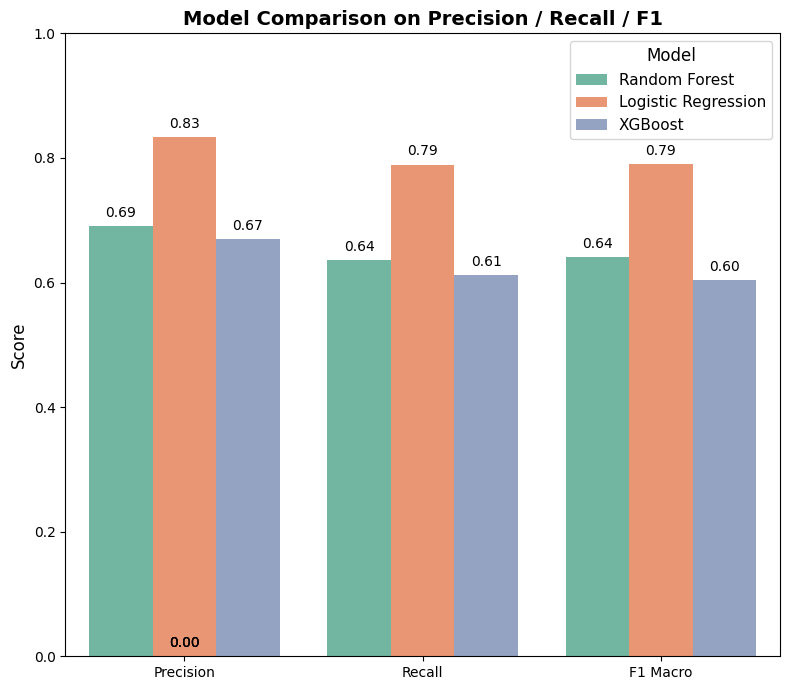

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


metrics_df = pd.DataFrame(metrics_summary).T

metrics_vis = metrics_df[["Precision", "Recall", "F1 Macro"]]


metrics_long = (
    metrics_vis
    .reset_index()
    .melt(id_vars="index", var_name="Metric", value_name="Score")
    .rename(columns={"index": "Model"})
)


plt.figure(figsize=(8, 7))
sns.barplot(
    data=metrics_long,
    x="Metric",
    y="Score",
    hue="Model",
    palette="Set2"  
)

ax = plt.gca()
for p in ax.patches:
    h = p.get_height()
    ax.annotate(
        f"{h:.2f}",
        (p.get_x() + p.get_width() / 2, h + 0.01),
        ha="center",
        va="bottom",
        fontsize=10
    )

ax.set_ylim(0, 1)
ax.set_title("Model Comparison on Precision / Recall / F1", fontsize=14, fontweight="bold")
ax.set_ylabel("Score", fontsize=12)
ax.set_xlabel("")
plt.legend(title="Model", fontsize=11, title_fontsize=12, loc="upper right")
plt.tight_layout()
plt.show()



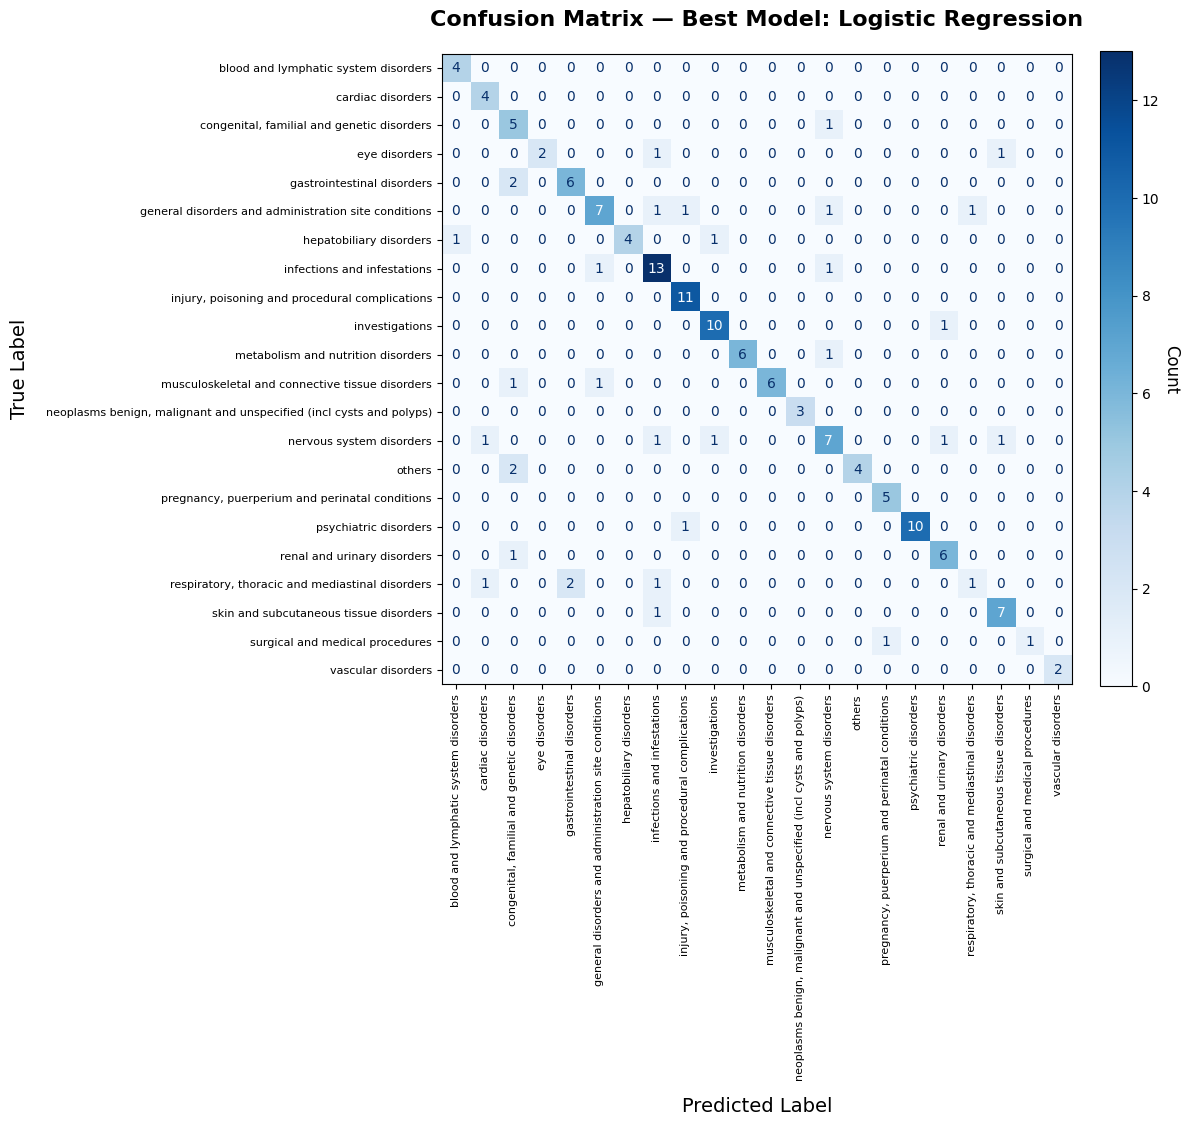

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

best_name = max(metrics_summary, key=lambda k: metrics_summary[k]["F1 Macro"])
best_clf  = fitted_clfs[best_name]
y_pred_b  = best_clf.predict(X_test)

cm     = confusion_matrix(y_test, y_pred_b)
labels = le.inverse_transform(unique_labels(y_test, y_pred_b))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(12, 12))

disp.plot(
    ax=ax,
    cmap="Blues",
    colorbar=False,       
    include_values=True,
    xticks_rotation=90,
    values_format="d",
    im_kw={"aspect": "equal"}
)

im   = disp.im_
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("Count", rotation=270, labelpad=15, fontsize=12)

ax.set_title(f"Confusion Matrix — Best Model: {best_name}", fontsize=16, fontweight="bold", pad=20)
ax.set_xlabel("Predicted Label", fontsize=14, labelpad=12)
ax.set_ylabel("True Label", fontsize=14, labelpad=12)
ax.tick_params(axis="x", labelsize=8, labelrotation=90)
ax.tick_params(axis="y", labelsize=8, labelrotation=0)

plt.tight_layout()
plt.show()


# External

In [ ]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
from sklearn.utils.multiclass import unique_labels

external_df = pd.read_csv("./Relevant dateset/Evaludate dateset.csv.csv", dtype=str)
external_df = external_df.dropna(subset=["SOC Cluster"])
external_df["ae_text"] = external_df["Adverse Event"].astype(str).str.lower().str.strip()
external_df["label"]   = external_df["SOC Cluster"].astype(str).str.lower().str.strip()

external_df["label_merged"] = external_df["label"].apply(
    lambda x: "others" if x in rare_labels else x
)

external_df = external_df[external_df["label_merged"].isin(le.classes_)].reset_index(drop=True)

model_name = "dmis-lab/biobert-base-cased-v1.1"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model     = AutoModel.from_pretrained(model_name)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def get_embeddings(texts, tokenizer, model, device, max_length=128):
    hidden_size = model.config.hidden_size
    embeddings = []
    with torch.no_grad():
        for txt in texts:
            if not txt:
                embeddings.append(np.zeros(hidden_size))
                continue
            inputs = tokenizer(txt, return_tensors="pt", truncation=True,
                               padding="max_length", max_length=max_length)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = model(**inputs)
            cls_vec = outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()
            embeddings.append(cls_vec)
    return np.vstack(embeddings)

print("Encoding external data with BioBERT...")
X_ext = get_embeddings(external_df["ae_text"].tolist(), tokenizer, model, device)

y_ext = le.transform(external_df["label_merged"])

y_pred_ext = best_clf.predict(X_ext)

labels_ext = unique_labels(y_ext, y_pred_ext)
print("\n📊 External Evaluation Report:")
print(classification_report(
    y_ext, y_pred_ext,
    labels=labels_ext,
    target_names=le.inverse_transform(labels_ext)
))

acc_ext  = accuracy_score(y_ext, y_pred_ext)
f1_ext   = f1_score(y_ext, y_pred_ext, average="macro")
prec_ext = precision_score(y_ext, y_pred_ext, average="macro")
rec_ext  = recall_score(y_ext, y_pred_ext, average="macro")

print(f"\n  External Accuracy:  {acc_ext:.4f}")
print(f"  External F1 Macro:  {f1_ext:.4f}")
print(f"  External Precision: {prec_ext:.4f}")
print(f"  External Recall:    {rec_ext:.4f}")



e:\anaconda3\envs\Biobert_env\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


🔄 Encoding external data with BioBERT...

📊 External Evaluation Report:
                                                                     precision    recall  f1-score   support

                               blood and lymphatic system disorders       0.89      0.83      0.86        30
                                                  cardiac disorders       0.75      0.90      0.82        40
                         congenital, familial and genetic disorders       0.63      0.82      0.71        44
                                                      eye disorders       0.84      0.82      0.83        38
                                         gastrointestinal disorders       0.82      0.83      0.82        64
               general disorders and administration site conditions       0.71      0.76      0.73        58
                                            hepatobiliary disorders       0.82      0.82      0.82        33
                                        infections and 

e:\anaconda3\envs\Biobert_env\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


🔄 Encoding external data with BioBERT...

📊 External Evaluation Report:
                                                                     precision    recall  f1-score   support

                               blood and lymphatic system disorders       0.89      0.83      0.86        30
                                                  cardiac disorders       0.75      0.90      0.82        40
                         congenital, familial and genetic disorders       0.63      0.82      0.71        44
                                                      eye disorders       0.84      0.82      0.83        38
                                         gastrointestinal disorders       0.82      0.83      0.82        64
               general disorders and administration site conditions       0.71      0.76      0.73        58
                                            hepatobiliary disorders       0.82      0.82      0.82        33
                                        infections and 

In [21]:
import pandas as pd

# Create the DataFrame with external validation metrics
metrics = {
    "Metric": ["External Accuracy", "External F1 Macro", "External Precision", "External Recall"],
    "Value": [0.8354, 0.8250, 0.8332, 0.8257]
}

df_metrics = pd.DataFrame(metrics)
df_metrics


,Metric,Value
0,External Accuracy,0.8354
1,External F1 Macro,0.8250
2,External Precision,0.8332
3,External Recall,0.8257


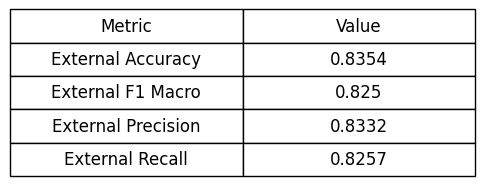

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Prepare your metrics
metrics = {
    "Metric": [
        "External Accuracy",
        "External F1 Macro",
        "External Precision",
        "External Recall"
    ],
    "Value": [
        0.8354,
        0.8250,
        0.8332,
        0.8257
    ]
}
df_metrics = pd.DataFrame(metrics)

# 2. Plot as a table
fig, ax = plt.subplots(figsize=(6, 2))
ax.axis("off")  # no axes

# Create the table
table = ax.table(
    cellText=df_metrics.values,
    colLabels=df_metrics.columns,
    cellLoc="center",
    loc="center"
)

# Styling
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 2)

plt.show()


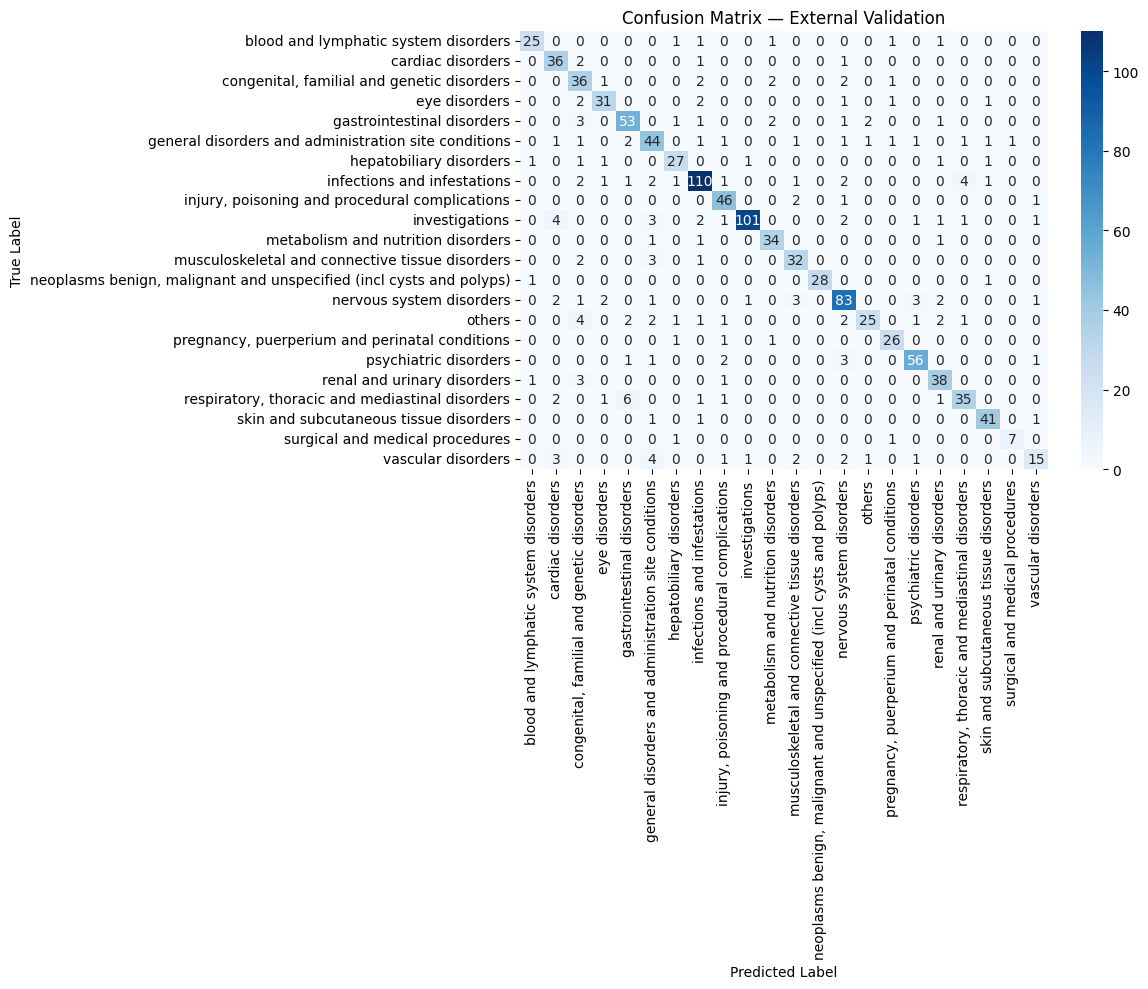

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_ext, y_pred_ext, labels=labels_ext)


plt.figure(figsize=(12,10))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=le.inverse_transform(labels_ext),
    yticklabels=le.inverse_transform(labels_ext)
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix — External Validation")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
